In [25]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.python.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

In [5]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256

# cataract dataset
IMG_ROOT = './data/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal', 
           IMG_ROOT+'2_cataract', 
           IMG_ROOT+'2_glaucoma', 
           IMG_ROOT+'3_retina_disease']

# ocular-disease-recognition dataset
OCU_IMG_ROOT = './data/ODIR-5K/Training Images/'
ocu_df = pd.read_excel('./data/ODIR-5K/data.xlsx')

In [6]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [7]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(601))

filepaths = glob.glob(IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[2]:  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == IMG_DIR[3]:  # retine_disease
        cat_df.iloc[i, 1] = 3
        
# only sample normal and cataract        
cat_df = cat_df.query('0 <= cataract < 2')
cat_df

paths  cataract
0                ./data/dataset\1_normal/NL_001.png         0
1                ./data/dataset\1_normal/NL_002.png         0
2                ./data/dataset\1_normal/NL_003.png         0
3                ./data/dataset\1_normal/NL_004.png         0
4                ./data/dataset\1_normal/NL_005.png         0
..                                              ...       ...
596  ./data/dataset\3_retina_disease/Retina_096.png         0
597  ./data/dataset\3_retina_disease/Retina_097.png         0
598  ./data/dataset\3_retina_disease/Retina_098.png         0
599  ./data/dataset\3_retina_disease/Retina_099.png         0
600  ./data/dataset\3_retina_disease/Retina_100.png         0

[601 rows x 2 columns]

In [8]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

Number of normal and cataract images
0    601
Name: cataract, dtype: int64


In [9]:
ocu_df.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   3           66        Male  3_left.jpg  3_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
0                           normal fundus  0  0  0  1  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  
3         branch retinal artery occlusion  0  0  0  0  0  0  0  1  
4       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1

In [10]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0
    
ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))

In [11]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']]\
        .rename(columns={'left_eye_cataract':'cataract'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']]\
        .rename(columns={'right_eye_cataract':'cataract'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [12]:
le_df.head()

cataract                                      paths
0         1  ./data/ODIR-5K/Training Images/0_left.jpg
1         0  ./data/ODIR-5K/Training Images/1_left.jpg
2         0  ./data/ODIR-5K/Training Images/2_left.jpg
3         0  ./data/ODIR-5K/Training Images/3_left.jpg
4         0  ./data/ODIR-5K/Training Images/4_left.jpg

In [13]:
re_df.head()

cataract                                       paths
0         0  ./data/ODIR-5K/Training Images/0_right.jpg
1         0  ./data/ODIR-5K/Training Images/1_right.jpg
2         0  ./data/ODIR-5K/Training Images/2_right.jpg
3         0  ./data/ODIR-5K/Training Images/3_right.jpg
4         0  ./data/ODIR-5K/Training Images/4_right.jpg

In [14]:
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
0    3341
1     159
Name: cataract, dtype: int64

Number of right eye images
0    3346
1     154
Name: cataract, dtype: int64


In [15]:
def downsample(df):
    df = pd.concat([
        df.query('cataract==1'),
        df.query('cataract==0').sample(sum(df['cataract']), 
                                       random_state=SEED)
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
1    159
0    159
Name: cataract, dtype: int64

Number of right eye images
1    154
0    154
Name: cataract, dtype: int64


In [16]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

cataract                                        paths
0           1    ./data/ODIR-5K/Training Images/0_left.jpg
81          1   ./data/ODIR-5K/Training Images/81_left.jpg
103         1  ./data/ODIR-5K/Training Images/103_left.jpg
119         1  ./data/ODIR-5K/Training Images/119_left.jpg
253         1  ./data/ODIR-5K/Training Images/254_left.jpg

In [17]:
df = pd.concat([cat_df, ocu_df], ignore_index=True)
df

paths  cataract
0                ./data/dataset\1_normal/NL_001.png         0
1                ./data/dataset\1_normal/NL_002.png         0
2                ./data/dataset\1_normal/NL_003.png         0
3                ./data/dataset\1_normal/NL_004.png         0
4                ./data/dataset\1_normal/NL_005.png         0
...                                             ...       ...
1222   ./data/ODIR-5K/Training Images/943_right.jpg         0
1223  ./data/ODIR-5K/Training Images/2943_right.jpg         0
1224  ./data/ODIR-5K/Training Images/3957_right.jpg         0
1225   ./data/ODIR-5K/Training Images/199_right.jpg         0
1226   ./data/ODIR-5K/Training Images/376_right.jpg         0

[1227 rows x 2 columns]

In [18]:
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [19]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:13<00:00, 18.25it/s]


C:\Users\juiklee\AppData\Local\Temp\ipykernel_5444\256115694.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  norm_list = list(train_df[0][:25])


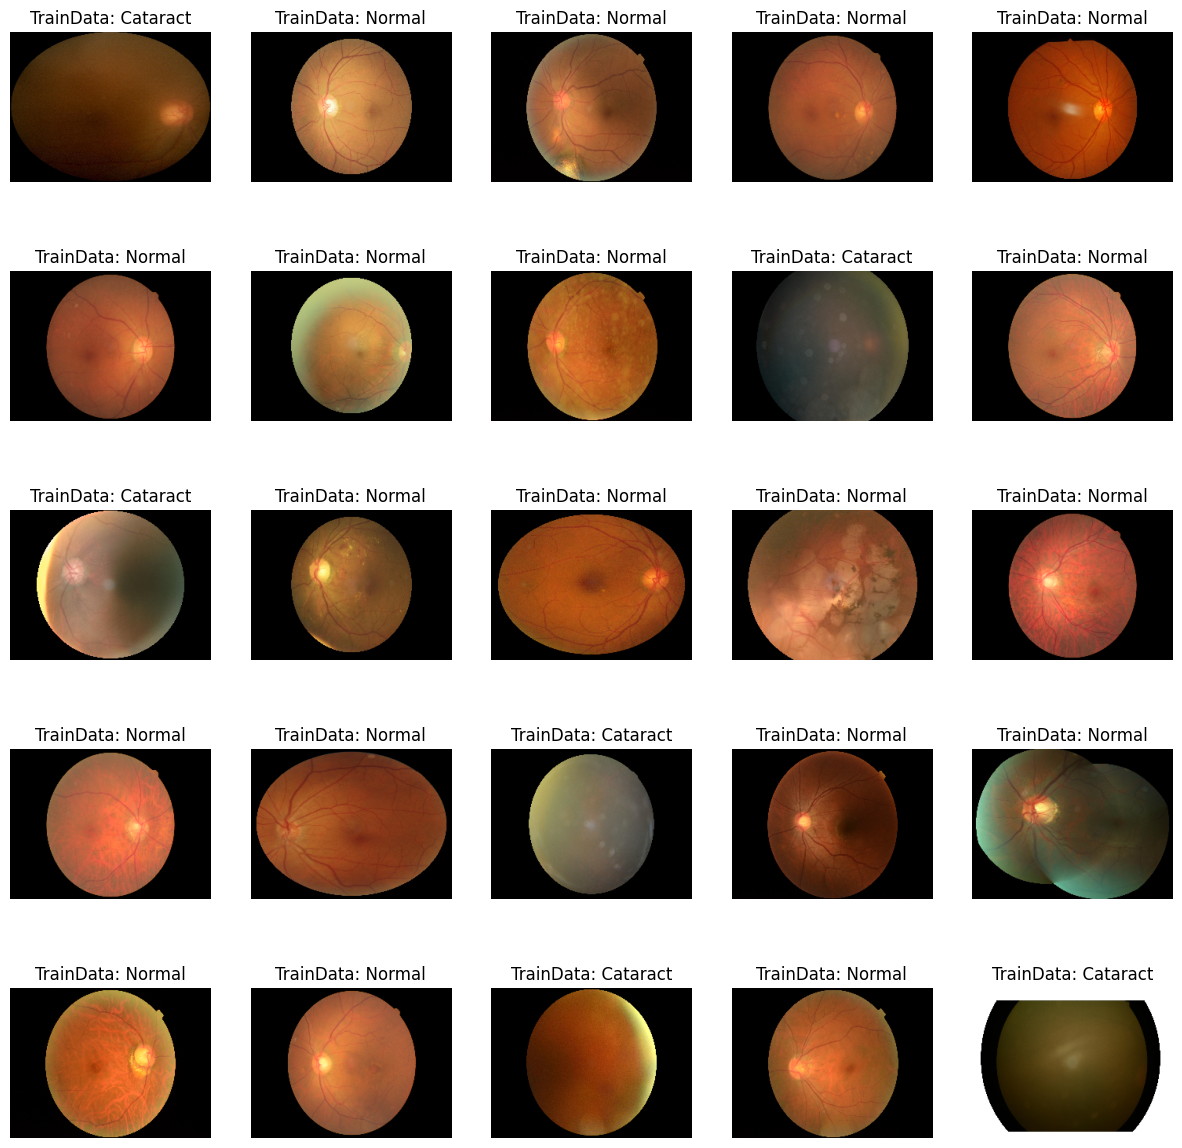

In [20]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

C:\Users\juiklee\AppData\Local\Temp\ipykernel_5444\1779978884.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  norm_list = list(test_df[0][:25])


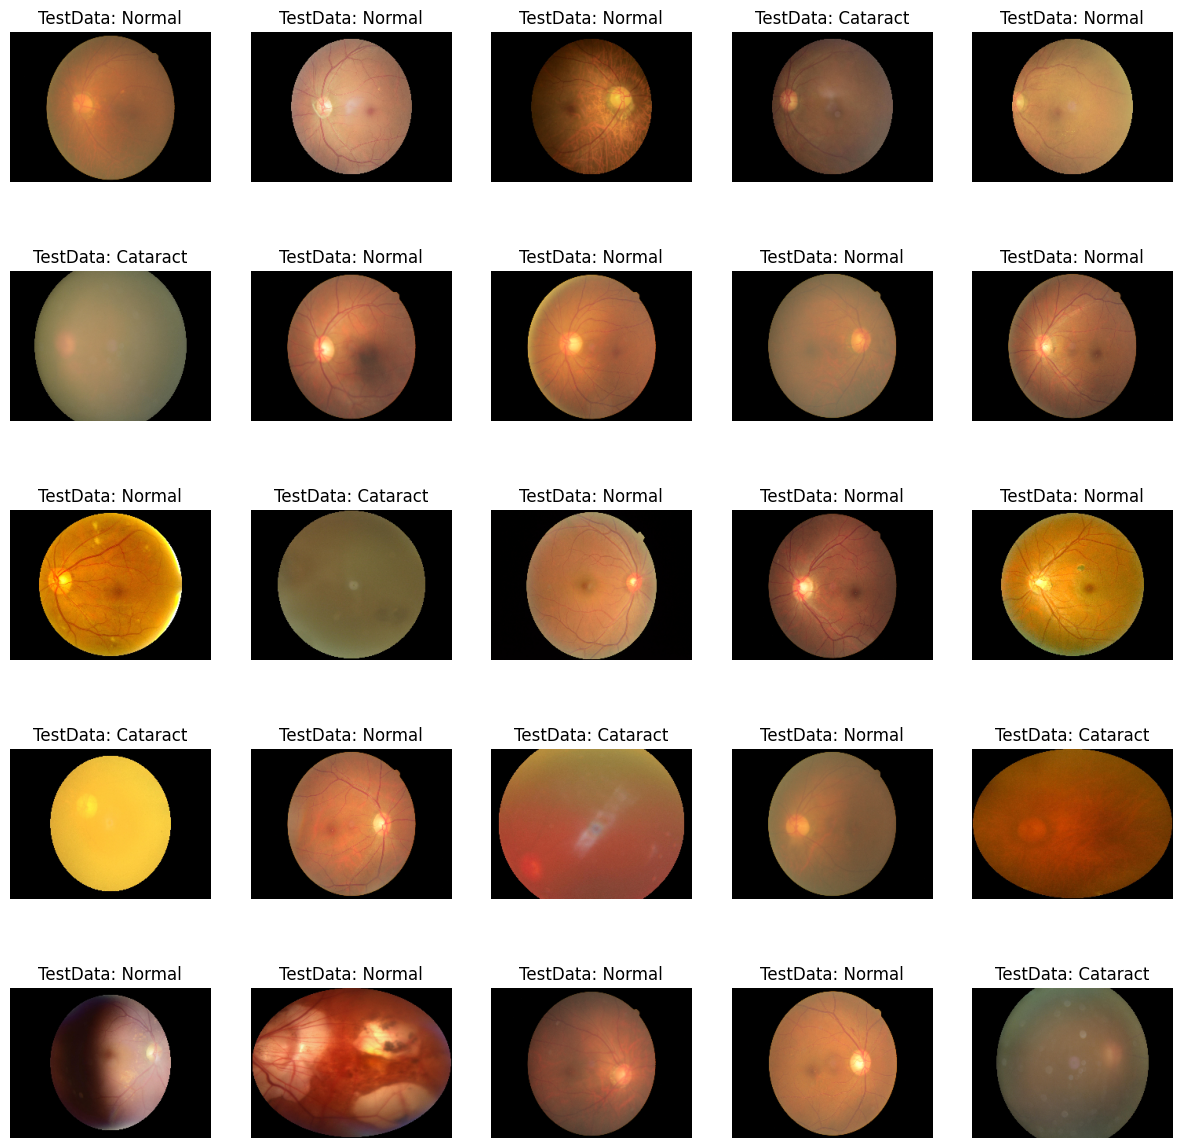

In [21]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

In [22]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 efficientnet-b0 (Functional  (None, 6, 8, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [23]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
26/26 [==============================] - 79s 3s/step - loss: 0.7264 - accuracy: 0.4982 - val_loss: 0.7883 - val_accuracy: 0.2838 - lr: 3.0000e-06
Epoch 2/100
26/26 [==============================] - 66s 3s/step - loss: 0.6738 - accuracy: 0.5714 - val_loss: 0.7106 - val_accuracy: 0.4122 - lr: 3.0000e-06
Epoch 3/100
26/26 [==============================] - 68s 3s/step - loss: 0.6066 - accuracy: 0.6723 - val_loss: 0.6432 - val_accuracy: 0.6284 - lr: 3.0000e-06
Epoch 4/100
26/26 [==============================] - 68s 3s/step - loss: 0.5629 - accuracy: 0.7683 - val_loss: 0.5968 - val_accuracy: 0.7500 - lr: 3.0000e-06
Epoch 5/100
26/26 [==============================] - 69s 3s/step - loss: 0.5203 - accuracy: 0.8067 - val_loss: 0.5616 - val_accuracy: 0.7838 - lr: 3.0000e-06
Epoch 6/100
26/26 [==============================] - 69s 3s/step - loss: 0.4858 - accuracy: 0.8535 - val_loss: 0.5287 - val_accuracy: 0.8311 - lr: 3.0000e-06
Epoch 7/100
26/26 [==============================] -

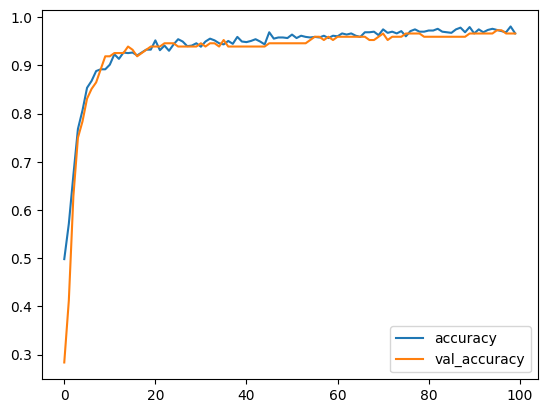

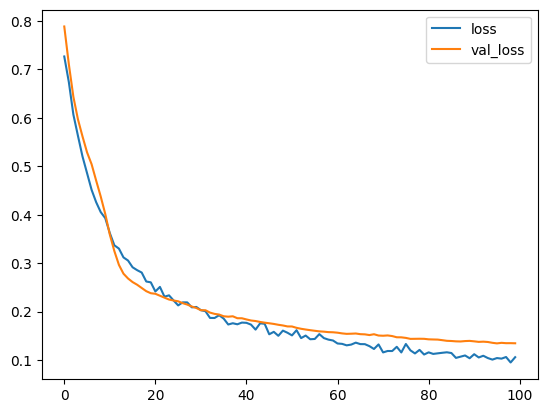

In [22]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [28]:
model.evaluate(test_imgs, test_df)

8/8 [==============================] - 4s 491ms/step - loss: 0.1079 - accuracy: 0.9553


[0.10788046568632126, 0.9552845358848572]

In [30]:
model.save("model.h5")